# 多分类任务

## 1.简介

多分类任务是通过学习数据的分布进行分类训练，不同于逻辑回归，分类任务的最终结果是一个类别。但是本次实验的网络结构仍然是采用含有一个隐藏层的SVM，这与上次的逻辑回归是一样的。

## 2.数据准备

这次让输入的向量是二维的，代表有两个features，输出分别是0和1。生成数据时用torch.normal产生，这个函数可以通过输入的mean和std产生独立同分布的数据。比如需要生成100组二维数据，并且二维数据每一维的均值都是1，那么可以由以下代码生成：

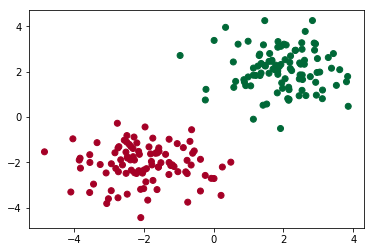

In [2]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torch.utils.data as Data
%matplotlib inline
regulation_tensor = torch.ones(100, 2)
x0 = torch.normal(mean=2*regulation_tensor, std=1)
y0 = torch.ones(100)
x1 = torch.normal(mean=-2*regulation_tensor, std=1)
y1 = torch.zeros(100)
x = torch.cat((x0, x1), 0)
y = torch.cat((y0, y1), ).type(torch.LongTensor)
dataset = Data.TensorDataset(x, y)
dataiter = Data.DataLoader(dataset=dataset, 
                           batch_size=10,
                           shuffle=True)
plt.scatter(x=x.data.numpy()[:, 0], y=x.data.numpy()[:, 1], c=y.data.numpy(), cmap='RdYlGn')
plt.show()

## 2.定义网络结构

网络结构和逻辑回归没有大的区别，要注意的是，回归问题的输出大小应该与类别的数量有关。

In [7]:
class Net(nn.Module):
    """
    自定义网络
    """
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden_out = nn.Linear(n_feature, n_hidden)
        self.output = nn.Linear(n_hidden, n_output)

    def forward(self, x):
        x = F.relu(self.hidden_out(x))
        y = self.output(x)
        return y
net = Net(2, 5, 2)
print(net)

Net(
  (hidden_out): Linear(in_features=2, out_features=5, bias=True)
  (output): Linear(in_features=5, out_features=2, bias=True)
)


# 训练

本次由于是分类任务，所以采用的损失函数是交叉熵损失函数。在每个batch中，网络的输出是10*2的，而标签是1*10的，在逻辑回归任务中，输入到损失函数计算时需要进行size上的修改，但是交叉熵函数不用，第二个参数即标签可以是1维的。

In [10]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.02)
for epoch in range(10):
    for features, label in dataiter:
        criterion.zero_grad()
        output = net(features)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

# 测试

测试数据采用与训练数据同样的方法随机生成，得到输出后用softmax函数取得下标，其中softmax函数的第二个参数代表按行还是按列进行计算，这里我们是求每行的结果，所以第二个参数设置为1。最后的分类结果是softmax结果最大的下标，所以用torch.max函数一次性求出所有的下标，与softmax一样，第二个参数是用来设定是按行还是按列求最大，这里设置为1。

In [11]:
output = net(x)
prediction = torch.max(F.softmax(output, dim=1), 1)[1]
result = sum(prediction == y).item()/200
print(result)

1.0
